<h2>Imports and Function Definitions</h2>

In [1]:
from loading_data import *
from model import *
from model_2 import *
from visualize import *
import numpy as np
from main import *
import torch
import plotly.express as px
import plotly.io as pio
# pio.templates.default = "none"
pio.templates.default = "plotly_dark"

N_HIDDEN = 96  # NUMBER OF HIDDEN STATES
N_LAYER = 4  # NUMBER OF LSTM LAYERS
N_EPOCH = 150  # NUM OF EPOCHS
RUL_UPPER_BOUND = 135  # UPPER BOUND OF RUL
LR = 0.01  # LEARNING RATE

In [2]:
def get_rmse(arr1, arr2):
    """
    Calculate the RMSE between two arrays.
    """
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    rmse = np.sqrt(np.mean((arr1 - arr2) ** 2))
    return rmse

In [3]:
def get_X_y(unit_nr, group, test=False):
    """
    Get the X and y data for a specific unit number and group.
    """
    if test:
        X = group.get_group(unit_nr).iloc[:, 2:]
        X_tensors = Variable(torch.Tensor(X.to_numpy()))
        X_tensors = torch.reshape(X_tensors, (X_tensors.shape[0], 1, X_tensors.shape[1]))
        y_tensors = None
    else:
        X, y = group.get_group(unit_nr).iloc[:, 2:-1], group.get_group(unit_nr).iloc[:, -1:]
        X_tensors = Variable(torch.Tensor(X.to_numpy()))
        y_tensors = Variable(torch.Tensor(y.to_numpy()))
        X_tensors = torch.reshape(X_tensors, (X_tensors.shape[0], 1, X_tensors.shape[1]))
    
    return X_tensors, y_tensors

In [4]:
def plot_rul_vs_time(unit_nr, model, group_test, test=False, y_test_array=None, clip=False):
    """
    Plot the RUL over time for a given unit number.
    """
    if test:
        assert y_test_array is not None, "y_test_array must be provided for test data"

    X_tensors, y_tensors = get_X_y(unit_nr, group_test, test)
    
    model.eval()
    predicted_rul = model(X_tensors).detach().numpy()
    
    if test:
        strt, end = y_test_array[unit_nr - 1] + X_tensors.shape[0] - 1, y_test_array[unit_nr - 1] - 1
        true_rul = np.arange(strt, end, -1).reshape(predicted_rul.shape)
        if clip:
            true_rul.clip(max=RUL_UPPER_BOUND, out=true_rul)
    else:
        true_rul = y_tensors.detach().numpy()

    fig = px.line(
        x=np.arange(1, len(true_rul) + 1),
        y=true_rul.reshape(-1),
        title=f'RUL Over Time: Unit {unit_nr}',
        labels={'x': 'Time', 'y': 'RUL'},
        markers=False
    )
    fig.add_scatter(
        x=np.arange(1, len(predicted_rul) + 1),
        y=predicted_rul.reshape(-1),
        mode='lines',
        name='Predicted RUL'
    )
    fig.update_layout(
        legend=dict(yanchor="bottom",
                    y=0.1,
                    xanchor="left",
                    x=0.1)
    )
    fig.show()
    

In [5]:
def normalize_data(df, type='minmax', test=False, stats = None):
    """
    Normalize the input data.
    """ 
    title = df.iloc[:, 0:2]
    data = df.iloc[:, 2:]
    
    if not test:
        if type == 'minmax':
            train_min, train_max = data.min(), data.max()
            data_norm = (data - train_min) / (train_max - train_min)
            stats = (train_min, train_max)
        elif type == 'zscore':
            train_mean, train_std = data.mean(), data.std()
            data_norm = (data - train_mean) / train_std
            stats = (train_mean, train_std)
        else:
            raise ValueError("Normalization type must be 'minmax' or 'zscore'")
        return pd.concat([title, data_norm], axis=1), stats
    else:
        assert stats is not None, "stats must be provided for test data"
        if type == 'minmax':
            train_min, train_max = stats
            data_norm = (data - train_min) / (train_max - train_min)
        elif type == 'zscore':
            train_mean, train_std = stats
            data_norm = (data - train_mean) / train_std
        else:
            raise ValueError("Normalization type must be 'minmax' or 'zscore'")
        return pd.concat([title, data_norm], axis=1)
    
        
    

In [6]:
def load_FD001(rul_ub=None, norm_type='minmax'):
    """
    Load and preprocess the FD001 dataset.
    :param rul_ub: upper limit for target RULs
    :return: grouped data per sample
    """
    # load data FD001.py
    # define filepath to read data
    dir_path = './CMAPSSData/'

    # define column names for easy indexing
    index_names = ['unit_nr', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
    col_names = index_names + setting_names + sensor_names

    # read data
    train_data = pd.read_csv((dir_path + 'train_FD001.txt'), sep='\s+', header=None, names=col_names)
    test_data = pd.read_csv((dir_path + 'test_FD001.txt'), sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv((dir_path + 'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

    # drop non-informative features, derived from EDA
    drop_sensors = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
    drop_labels = setting_names + drop_sensors
    train_data.drop(labels=drop_labels, axis=1, inplace=True)
    test_data.drop(labels=drop_labels, axis=1, inplace=True)
    
    # normalize data
    train_norm, train_stats = normalize_data(train_data, type=norm_type)
    test_norm = normalize_data(test_data, type=norm_type, test=True, stats=train_stats)
    
    # add RUL to training data
    # as in piece-wise linear function, there is an upper limit for target RUL,
    # however, experimental results shows this goes even better without it:
    train_norm = add_rul_1(train_norm)
    if rul_ub is not None:
        train_norm['RUL'].clip(upper=rul_ub, inplace=True)
        
    group_test = test_norm.groupby(by="unit_nr")
    group = train_norm.groupby(by="unit_nr")

    return group, group_test, y_test

<h2>Load Data and Train Base Model</h2>

In [10]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()
# fetch basic information from data sets
group_train, group_test, y_test = load_FD001()
y_test_array = y_test.to_numpy()  # convert to numpy array
num_train, num_test = len(group_train.size()), len(group_test.size())
input_size = group_train.get_group(1).shape[1] - 3  # number of features

# LSTM model initialization
model = LSTM1(input_size, N_HIDDEN, N_LAYER)  # our lstm class

load_model(model, './results/model_base_H96L4_rmse23p66.pth')  # load the pre-trained model
model.eval()  # set the model to evaluation mode
criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Model loaded from ./results/model_base_H96L4_rmse23p66.pth


/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/main.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [ ]:
result, rmse = train(model, num_train, num_test, group_train, group_test, criterion, optimizer, y_test_array)
# result, rmse = testing_function(model, num_test, group_test, y_test)
visualize(result, y_test, num_test, rmse)

In [51]:
outputs_one_at_a_time = []
for i in range(-192, -1):
    X = group_train.get_group(1).iloc[i:i+1, 2:-1]
    X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
    X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    outputs_one_at_a_time.append(model(X_train_tensors).detach().numpy())  # forward pass
X = group_train.get_group(1).iloc[-1:, 2:-1]
X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
outputs_one_at_a_time.append(model(X_train_tensors).detach().numpy())  # forward pass

outputs_one_at_a_time = np.array(outputs_one_at_a_time)
outputs_one_at_a_time = outputs_one_at_a_time.reshape((192,1))

In [ ]:
outputs_all = outputs.detach().numpy()

In [52]:
diff = outputs_one_at_a_time - outputs_all

In [154]:
# save_model(model, './results/model_base_H96L4_rmse22p36.pth')  # save the model
model.eval()  # set the model to evaluation mode
# y_test_array = y_test.to_numpy()  # convert to numpy array

LSTM1(
  (lstm): LSTM(15, 96, num_layers=4, batch_first=True, dropout=0.1)
  (fc_1): Linear(in_features=96, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=8, bias=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

<h2>Get RUL v/s Time plots for Test and Train Datasets</h2>

In [ ]:
plot_rul_vs_time(unit_nr=49, model=model, group_test=group_test, test=True, y_test_array=y_test_array)

<h2>Dependence of Error on RUL and Sequence Length</h2>

<h3>Test Data</h3>

In [ ]:
rul_seqlen_err = list()#np.zeros((100, 3))
for unit_nr in range(1, num_test + 1):
    X_test = group_test.get_group(unit_nr).iloc[:, 2:]
    X_test_tensors = Variable(torch.Tensor(X_test.to_numpy()))
    X_test_tensors = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

    predicted_rul = model(X_test_tensors).detach().numpy()[-1].item()
    true_rul = y_test_array[unit_nr - 1][0].item()
    rul_err = true_rul - predicted_rul
    rul_seqlen_err.append([true_rul, X_test.shape[0], rul_err])

rul_seqlen_err = np.array(rul_seqlen_err).T
rul_seqlen_err[2] = np.abs(rul_seqlen_err[2])

# px.line(x=np.arange(1, len(true_rul) + 1), y=((true_rul - predicted_rul)).reshape(-1), title='RUL Error Over Time', labels={'x': 'Time', 'y': 'RUL Error'}, markers=False).show()

In [ ]:
px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    color=rul_seqlen_err[2],
    title='True RUL vs Sequence Length',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'color': 'RUL Error'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[1],
    title='True RUL vs RUL Error',
    labels={'x': 'True RUL', 'y': 'RUL Error', 'color': 'Sequence Length'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[1],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[0],
    title='Sequence Length vs RUL Error',
    labels={'x': 'Sequence Length', 'y': 'RUL Error', 'color': 'True RUL'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()


In [ ]:
fig = px.scatter_3d(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    z=rul_seqlen_err[2],
    title='3D Scatter Plot of True RUL, Sequence Length, and RUL Error',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'z': 'RUL Error'},
    color=rul_seqlen_err[2],
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(
    autosize=False,
    width=700,
    height=800
)
fig.show()

<h3>Train Data</h3>

In [162]:
### get the rul_seqlen_err for training data
rul_seqlen_err = list()#np.zeros((100, 3))
for unit_nr in range(1, num_train + 1):
    X_train = group_train.get_group(unit_nr).iloc[:, 2:-1]
    X_train_tensors = Variable(torch.Tensor(X_train.to_numpy()))
    X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

    predicted_rul = model(X_train_tensors).detach().numpy()[-1].item()
    true_rul = 0
    rul_err = true_rul - predicted_rul
    rul_seqlen_err.append([true_rul, X_train.shape[0], rul_err, unit_nr, predicted_rul])

rul_seqlen_err = np.array(rul_seqlen_err).T
rul_seqlen_err[2] = np.abs(rul_seqlen_err[2])

In [163]:
px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    color=rul_seqlen_err[2],
    title='True RUL vs Sequence Length',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'color': 'RUL Error'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[1],
    title='True RUL vs RUL Error',
    labels={'x': 'True RUL', 'y': 'RUL Error', 'color': 'Sequence Length'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[1],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[0],
    title='Sequence Length vs RUL Error',
    labels={'x': 'Sequence Length', 'y': 'RUL Error', 'color': 'True RUL'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()

In [164]:
fig = px.scatter_3d(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    z=rul_seqlen_err[2],
    title='3D Scatter Plot of True RUL, Sequence Length, and RUL Error',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'z': 'RUL Error', 'color': 'Unit_nr'},
    color=rul_seqlen_err[3],
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700
)
fig.show()

<h2>Normalising Test Data w.r.t. stats of Train data</h2>

In [168]:
# load data FD001.py
# define filepath to read data
dir_path = './CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

train_data = pd.read_csv((dir_path + 'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test_data = pd.read_csv((dir_path + 'test_FD001.txt'), sep='\s+', header=None, names=col_names)
    
# drop non-informative features, derived from EDA
drop_sensors = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
drop_labels = setting_names + drop_sensors

train_data.drop(labels=drop_labels, axis=1, inplace=True)
data = train_data.iloc[:, 2:]
train_max, train_min = data.max(), data.min()

test_data.drop(labels=drop_labels, axis=1, inplace=True)
title = test_data.iloc[:, 0:2]
data = test_data.iloc[:, 2:]
data_norm = (data - train_min) / (train_max - train_min)
test_norm = pd.concat([title, data_norm], axis=1)
group_test_new = test_norm.groupby(by="unit_nr")

In [198]:
unit_nr = 8
plot_rul_vs_time(unit_nr, model=model, group_test=group_test, test=True, y_test_array=y_test_array)
plot_rul_vs_time(unit_nr, model=model, group_test=group_test_new, test=True, y_test_array=y_test_array)

/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_14562/2422412391.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_14562/2422412391.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [200]:
result, rmse = testing_function(model, num_test, group_test, y_test_array)
result_new, rmse_new = testing_function(model, num_test, group_test_new, y_test_array)

<h3>Train new model using new test data as validation</h3>

Epoch: 1, loss: 13833.12310, rmse: 70.35573
Epoch: 2, loss: 6870.81936, rmse: 47.59471
Epoch: 3, loss: 4794.39912, rmse: 48.89797
Epoch: 4, loss: 4790.04322, rmse: 48.83697
Epoch: 5, loss: 4761.05243, rmse: 48.81495
Epoch: 6, loss: 4731.01156, rmse: 48.80499
Epoch: 7, loss: 4726.70564, rmse: 48.77643
Epoch: 8, loss: 4691.50444, rmse: 48.73055
Epoch: 9, loss: 4739.02826, rmse: 48.38647
Epoch: 10, loss: 4688.63420, rmse: 48.52514
Epoch: 11, loss: 4622.24165, rmse: 48.51561
Epoch: 12, loss: 4650.15142, rmse: 48.43091
Epoch: 13, loss: 4624.86166, rmse: 48.19934
Epoch: 14, loss: 4636.43653, rmse: 48.20259
Epoch: 15, loss: 4642.08971, rmse: 47.84828
Epoch: 16, loss: 4587.11911, rmse: 47.86125
Epoch: 17, loss: 4549.37569, rmse: 47.95895
Epoch: 18, loss: 4544.37726, rmse: 47.69507
Epoch: 19, loss: 4523.28587, rmse: 47.57037
Epoch: 20, loss: 4507.03589, rmse: 47.39802
Epoch: 21, loss: 4462.92035, rmse: 47.42532
Epoch: 22, loss: 4483.58969, rmse: 47.41102
Epoch: 23, loss: 4441.72552, rmse: 47.30

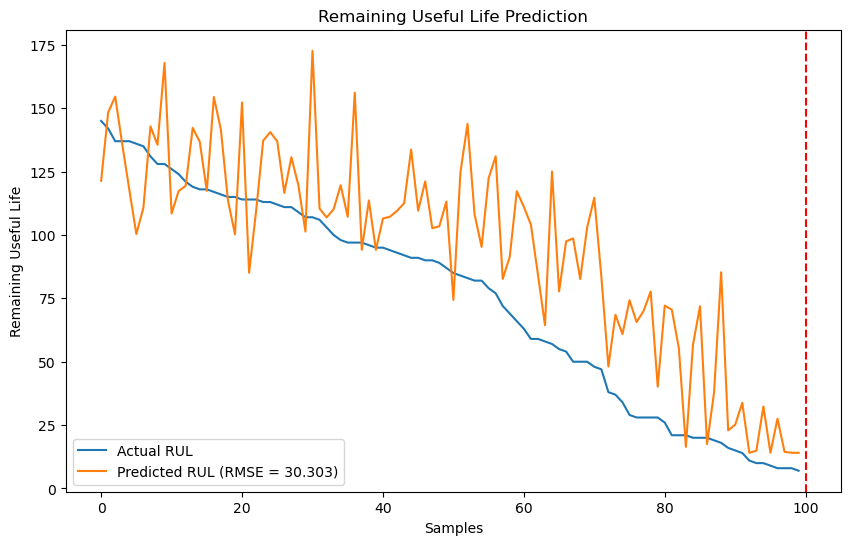

In [215]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()

# LSTM model initialization
model_new = LSTM1(input_size, N_HIDDEN, N_LAYER)  # our lstm class

# load_model(model, './results/model_base_H96L4.pth')  # load the pre-trained model
# model.eval()  # set the model to evaluation mode
criterion_new = torch.nn.MSELoss()  # mean-squared error for regression
optimizer_new = torch.optim.Adam(model_new.parameters(), lr=LR)


result_new, rmse_new = train(model_new, num_train, num_test, group_train, group_test_new, criterion_new, optimizer_new, y_test_array)
# result, rmse = testing_function(model, num_test, group_test, y_test)
visualize(result_new, y_test, num_test, rmse_new)

In [214]:
unit_nr = 100
plot_rul_vs_time(unit_nr, model=model, group_test=group_test, test=True, y_test_array=y_test_array)
plot_rul_vs_time(unit_nr, model=model_new, group_test=group_test_new, test=True, y_test_array=y_test_array)

/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_14562/2422412391.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_14562/2422412391.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



<h2>Try Z-Normalization and Clipping</h2>

In [7]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()
# fetch basic information from data sets
group_train_z, group_test_z, y_test_z = load_FD001(norm_type='zscore', rul_ub=RUL_UPPER_BOUND)
y_test_z_array = y_test_z.to_numpy()  # convert to numpy array
num_train_z, num_test_z = len(group_train_z.size()), len(group_test_z.size())
input_size_z = group_train_z.get_group(1).shape[1] - 3  # number of features

# LSTM model initialization
model_z = LSTM1(input_size_z, N_HIDDEN, N_LAYER)  # our lstm class

# load_model(model, './results/model_base_H96L4.pth')  # load the pre-trained model
# model.eval()  # set the model to evaluation mode
criterion_z = torch.nn.MSELoss()  # mean-squared error for regression
optimizer_z = torch.optim.Adam(model_z.parameters(), lr=LR)

/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_55154/1893676988.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_norm['RUL'].clip(upper=rul_ub, inplace=True)


batch_first=False


In [ ]:
result_z, rmse_z = train(model_z, num_train_z, num_test_z, group_train_z, group_test_z, criterion_z, optimizer_z, y_test_z_array)
# result, rmse = testing_function(model, num_test, group_test, y_test)
visualize(result_z, y_test_z, num_test_z, rmse_z)

In [18]:
# plot_rul_vs_time(unit_nr=34, model=model_z, group_test=group_test_z, clip=True, test=True, y_test_array=y_test_z_array)
save_model(model=model_z, path='./results/model_base_H96L4_z-norm_rmse19p78.pth')  # save the model

Model saved to ./results/model_base_H96L4_z-norm_rmse19p78.pth


<h2>Effect of Learning Rate</h2>

In [7]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()
# fetch basic information from data sets
group_train_z, group_test_z, y_test_z = load_FD001(norm_type='zscore', rul_ub=RUL_UPPER_BOUND)
y_test_z_array = y_test_z.to_numpy()  # convert to numpy array
num_train_z, num_test_z = len(group_train_z.size()), len(group_test_z.size())
input_size_z = group_train_z.get_group(1).shape[1] - 3  # number of features

results = []
for h in [4, 8, 16, 32, 64]:
	for e in range(4):
		lr = 10**(-e)
		print(f"Learning Rate: {lr}, Hidden Size: {h}", end=" ")
		# LSTM model initialization
		model_z = LSTM1(input_size_z, hidden_size=h, num_layers=2)  # our lstm class
		criterion_z = torch.nn.MSELoss()  # mean-squared error for regression
		optimizer_z = torch.optim.Adam(model_z.parameters(), lr=lr)

		result_z, rmse_z = train(model_z, num_train_z, num_test_z, group_train_z, group_test_z, criterion_z, optimizer_z, y_test_z_array)
		# result, rmse = testing_function(model, num_test, group_test, y_test)
		# visualize(result_z, y_test_z, num_test_z, rmse_z)
		results.append([h, e, rmse_z])
		print(f"RMSE: {rmse_z}")

/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_51104/1893676988.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_norm['RUL'].clip(upper=rul_ub, inplace=True)


Learning Rate: 1, Hidden Size: 4 RMSE: 34.36882988297136
Learning Rate: 0.1, Hidden Size: 4 RMSE: 38.08496864831375
Learning Rate: 0.01, Hidden Size: 4 RMSE: 42.21963098794769
Learning Rate: 0.001, Hidden Size: 4 RMSE: 28.96394314908712
Learning Rate: 1, Hidden Size: 8 RMSE: 32.81515716949529
Learning Rate: 0.1, Hidden Size: 8 RMSE: 28.217933986431326
Learning Rate: 0.01, Hidden Size: 8 RMSE: 26.932689567787826
Learning Rate: 0.001, Hidden Size: 8 RMSE: 28.688630815652672
Learning Rate: 1, Hidden Size: 16 RMSE: 44.36378735785281
Learning Rate: 0.1, Hidden Size: 16 RMSE: 43.58336664640697
Learning Rate: 0.01, Hidden Size: 16 RMSE: 22.44945333157521
Learning Rate: 0.001, Hidden Size: 16 RMSE: 25.311950789176382
Learning Rate: 1, Hidden Size: 32 RMSE: 44.36378468657871
Learning Rate: 0.1, Hidden Size: 32 RMSE: 20.434472669150793
Learning Rate: 0.01, Hidden Size: 32 RMSE: 20.20735040935303
Learning Rate: 0.001, Hidden Size: 32 RMSE: 20.850550703701114
Learning Rate: 1, Hidden Size: 64 RMSE

In [16]:
results

array([[ 2.        ,  2.        ,  2.        ,  2.        ,  3.        ,
         3.        ,  3.        ,  3.        ,  4.        ,  4.        ,
         4.        ,  4.        ,  5.        ,  5.        ,  5.        ,
         5.        ,  6.        ,  6.        ,  6.        ,  6.        ],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  0.        ,
         1.        ,  2.        ,  3.        ,  0.        ,  1.        ,
         2.        ,  3.        ,  0.        ,  1.        ,  2.        ,
         3.        ,  0.        ,  1.        ,  2.        ,  3.        ],
       [34.36882988, 38.08496865, 42.21963099, 28.96394315, 32.81515717,
        28.21793399, 26.93268957, 28.68863082, 44.36378736, 43.58336665,
        22.44945333, 25.31195079, 44.36378469, 20.43447267, 20.20735041,
        20.8505507 , 44.36378736, 21.36979084, 19.33788423, 19.91698928]])

In [25]:
px.scatter_3d(
    x=results[0],
	y=results[1],
	z=results[2],
	title='3D Scatter Plot of Hidden Size, Learning Rate, and RMSE',
	labels={'x': 'Hidden Size', 'y': 'Learning Rate', 'z': 'RMSE'},
	color=results[2],
	color_continuous_scale=px.colors.sequential.Viridis
).show()

<h2>Try batch_first = False</h2>

In [39]:
def testing_function_3(model, num_test, group_test, y_test):
    rmse_test, result_test = 0, list()

    for ite in range(1, num_test + 1):
        X_test = group_test.get_group(ite).iloc[:, 2:]
        X_test_tensors = Variable(torch.Tensor(X_test.to_numpy()))
        X_test_tensors = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

        test_predict = model(X_test_tensors)
        data_predict = max(test_predict[-1].detach().numpy(), 0)
        result_test.append(data_predict)
        rmse_test = np.add(np.power((data_predict - y_test[ite - 1]), 2), rmse_test)

    rmse_test = (np.sqrt(rmse_test / num_test)).item()
    return result_test, rmse_test


def train_3(model, num_train, num_test, group_train, group_test, loss_fn, optimizer, y_test):
    """

    :param model_for_train: initialized model
    :param ntrain: number of samples in training set
    :param group_for_train: grouped data per sample
    :return: evaluation results
    """
    rmse_temp = 100

    for epoch in range(1, N_EPOCH + 1):

        model.train()
        epoch_loss = 0

        for i in range(1, num_train + 1):
            X, y = group_train.get_group(i).iloc[:, 2:-1], group_train.get_group(i).iloc[:, -1:]
            X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
            y_train_tensors = Variable(torch.Tensor(y.to_numpy()))
            # X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

            outputs = model(X_train_tensors)  # forward pass

            optimizer.zero_grad()  # calculate the gradient, manually setting to 0
            loss = loss_fn(outputs, y_train_tensors)  # obtain the loss function
            epoch_loss += loss.item()
            loss.backward()  # calculates the loss of the loss function
            optimizer.step()  # improve from loss, i.e back propagation

        if epoch % 1 == 0:  # evaluate the model on testing set with each epoch
            model.eval()  # evaluate model
            result, rmse = testing_function(model, num_test, group_test, y_test)
            if rmse_temp < rmse and rmse_temp < 15:
                result, rmse = result_temp, rmse_temp
                break
            rmse_temp, result_temp = rmse, result  # store the last rmse
            print("Epoch: %d, loss: %1.5f, rmse: %1.5f" % (epoch, epoch_loss / num_train, rmse))

    return result, rmse

In [68]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class LSTM_3(nn.Module):
    """LSTM architecture"""

    def __init__(self, input_size, hidden_size, num_layers, seq_length=1):
        super(LSTM_3, self).__init__()
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers  # number of layers
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.1)
        print("batch_first=False")
        self.fc_1 = nn.Linear(hidden_size, 16)  # fully connected 1
        self.fc_2 = nn.Linear(16, 8)  # fully connected 2
        self.fc = nn.Linear(8, 1)  # fully connected last layer

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """

        :param x: input features
        :return: prediction results
        """
        # h_0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))  # hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))  # internal state
        output, (hn, cn) = self.lstm(x)  # lstm with input, hidden, and internal state

        hn_o = torch.Tensor(hn.detach().numpy()[-1, :])
        hn_o = hn_o.view(-1, self.hidden_size)
        hn_1 = torch.Tensor(hn.detach().numpy()[1, :])
        hn_1 = hn_1.view(-1, self.hidden_size)

        out_1 = self.relu(self.fc_1(self.relu(hn_o + hn_1)))
        out_2 = self.relu(self.fc_2(out_1))
        out_dp = self.dropout(out_2)
        out = self.fc(out_dp)
        return out, (hn, cn), out_1, out_2, out_dp


In [69]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()
# fetch basic information from data sets
group_train, group_test, y_test = load_FD001(norm_type='zscore', rul_ub=RUL_UPPER_BOUND)
y_test_array = y_test.to_numpy()  # convert to numpy array
num_train, num_test = len(group_train.size()), len(group_test.size())
input_size = group_train.get_group(1).shape[1] - 3  # number of features

# LSTM model initialization
model = LSTM_3(input_size, N_HIDDEN, N_LAYER)  # our lstm class
criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

batch_first=False


/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_55154/1893676988.py:37: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [45]:
result, rmse = train_3(model, num_train, num_test, group_train, group_test, criterion, optimizer, y_test_array)
# result, rmse = testing_function(model, num_test, group_test, y_test)
visualize(result, y_test, num_test, rmse)

/Users/neerajsohani/anaconda3/envs/lstm_rul_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning:

Using a target size (torch.Size([192, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/Users/neerajsohani/anaconda3/envs/lstm_rul_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning:

Using a target size (torch.Size([287, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/Users/neerajsohani/anaconda3/envs/lstm_rul_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning:

Using a target size (torch.Size([179, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/Users/neerajsohani/an

KeyboardInterrupt: 

In [70]:
X, y = group_train.get_group(1).iloc[:, 2:-1], group_train.get_group(1).iloc[:, -1:]
X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
y_train_tensors = Variable(torch.Tensor(y.to_numpy()))
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

outputs, (hn, cn), out_1, out_2, out_dp = model(X_train_tensors)  # forward pass

In [74]:
hn_o = torch.Tensor(hn.detach().numpy()[-1, :])
hn_o = hn_o.view(-1, 96)

In [77]:
hn.shape, hn_o.shape, out_1.shape, out_2.shape, out_dp.shape, outputs.shape

(torch.Size([4, 192, 96]),
 torch.Size([192, 96]),
 torch.Size([192, 16]),
 torch.Size([192, 8]),
 torch.Size([192, 8]),
 torch.Size([192, 1]))

<p>The original code is using each time step as individual batches. This should mean that the "time" part of learning is lost. Each prediction is based on the sensor output at the time itself, instead of taking into account all the previous time steps. This is explored in the next section.</p>

<h2>I think the original model is wrong because of the batch thing</h2>

In [53]:
# model, criterion, optimizer, group_train, group_test, y_test, result, rmse = run()
# fetch basic information from data sets
group_train, group_test, y_test = load_FD001()
y_test_array = y_test.to_numpy()  # convert to numpy array
num_train, num_test = len(group_train.size()), len(group_test.size())
input_size = group_train.get_group(1).shape[1] - 3  # number of features

# LSTM model initialization
model = LSTM1(input_size, N_HIDDEN, N_LAYER)  # our lstm class

load_model(model, './results/model_base_H96L4_rmse23p66.pth')  # load the pre-trained model
model.eval()  # set the model to evaluation mode
criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Model loaded from ./results/model_base_H96L4_rmse23p66.pth


/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/main.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [ ]:
"""
Computes the predictions for a given unit,
i.e., a given sequence of sensor data, in the standard way.
You give the entire sequence all at once and get a output array
with prediction for each time step. Ideally the prediction at time step t should
depend on the sensor data from all previous time steps.
"""
predictions_all_at_once = []
for unit_nr in range(1, 101):
    X = group_train.get_group(unit_nr).iloc[:, 2:-1]
    X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
    X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    predictions_all_at_once.append(model(X_train_tensors).detach().numpy().squeeze().reshape)  # forward pass

In [ ]:
"""
Computes the predictions for a given all time steps one at a time,
i.e., the model is called for each time step to get the prediction for that time step.
This ensures that the model is getting any past information for the prediction.
"""
predictions_one_at_a_time = []
for unit_nr in range(1, 101):
    unit_X = group_train.get_group(unit_nr).iloc[:, 2:-1]
    output = []
    # get all predictions one sensor data at a time
    for i in range(-unit_X.shape[0], -1):
        X = unit_X.iloc[i:i+1, :]
        X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
        X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        tmp = model(X_train_tensors).detach().numpy().squeeze()  # forward pass
        output.append(tmp)  # forward pass
    # get the last prediction
    X = unit_X.iloc[-1:, :]
    X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
    X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    output.append(model(X_train_tensors).detach().numpy().squeeze())  # forward pass
    output = np.array(output)
    output = output.reshape(-1)
    predictions_one_at_a_time.append(output)  # forward pass

In [ ]:
"""
Compares the two predictions for each time step for each unit.
"""
num_units_with_diff = 0
for unit_nr in range(1, 101):
    a, b = predictions_all_at_once[unit_nr - 1], predictions_one_at_a_time[unit_nr - 1]
    c = a - b
    stats = max(c).item(), min(c).item()
    if stats[0] != 0 and stats[1] != 0:
        num_units_with_diff += 1
        print(f"Unit {unit_nr}: Max: {stats[0]}, Min: {stats[1]}")
print(f"Number of units with different predictions: {num_units_with_diff}")

Number of units with different predictions: 0


<p>Both the predictions are exactly the same for all units and time steps. This means that the original code is not using the past sensor data to make the prediction for the current time step. THIS IS WRONG. This happens because the input of size (L,1,F) is being fed into the LSTM with batch_first=True. L - #TimeSteps, F - #Features. Hence, the LSTM is considering each time step as a separate batch!!</p>